# Notebook Pipeline for WSI image

## Imports & Variables

In [1]:
# Imports:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import openslide
import math
import cv2
import sys
import os

from stardist.models import StarDist2D
from stardist import random_label_cmap
from csbdeep.utils import normalize

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models.resnet import ResNet34_Weights

import pytorch_lightning as pl

from prodigyopt import Prodigy

In [18]:
# States:
np.random.seed(42)
lbl_cmap = random_label_cmap()

# Variables:
num_classes = 1 # Number of classes (classification)
pos_weight_value = 1000 # Weight value for positive class
tile_size = 256 # Size of tiles
margin = 3 # Margin for contouring
percentage=0.9 # Percentage of white needed in a tile to be removed
white_threshold=(200, 200, 200) # Threshold for white in RGBA
clas_threshold = 0.5 # Threshold for binary classification

# Paths:
wsi = '/Users/marcusnsr/Desktop/Bachelor/data_old/wsi1.ndpi' # Path to WSI

## Model loading

### Stardist

In [19]:
# Load the model:
Stardist_model = StarDist2D(None, name='NucleiSegmentor', basedir='models/')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.467853, nms_thresh=0.3.


### Classifier

In [20]:
# Check if MPS is available and set the device accordingly
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

class ImageClassifier(pl.LightningModule):
    def __init__(self, num_classes, pos_weight=None):
        super().__init__()
        weights = models.ResNet34_Weights.IMAGENET1K_V1
        self.model = models.resnet34(weights=weights)
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, num_classes)
        # Set up the weighted BCE Loss
        if pos_weight is not None:
            pos_weight = torch.tensor([pos_weight]).to(device)
            self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        else:
            self.criterion = torch.nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x).squeeze(1)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        labels = labels.float().to(device)  # Ensure labels are float and on the correct device for BCEWithLogitsLoss
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        labels = labels.float().to(device)  # Ensure labels are float and on the correct device for BCEWithLogitsLoss
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = Prodigy(self.parameters(), lr=1.)
        return optimizer
    
# Load the model
Classifier_model = ImageClassifier(num_classes=num_classes, pos_weight=pos_weight_value)
Classifier_model.load_state_dict(torch.load('models/neutrophil_classifier_best.pth', map_location=device))
Classifier_model.to(device)

ImageClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

# Pipeline

## (1) - Open, Selecct AoI

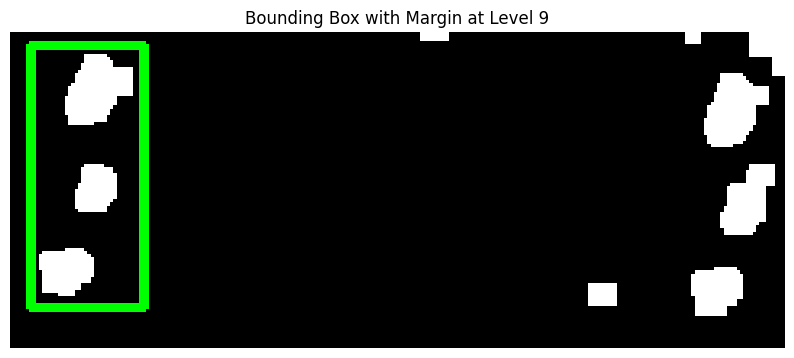

Scaled top-left and dimensions: (3072, 2048, 0, 17920, 41472)


In [21]:
# Open the WSI file
slide = openslide.OpenSlide(wsi)

# Get a lower level for a smaller image size
lower_level = slide.level_count - 1
lower_level_dimensions = slide.level_dimensions[lower_level]

# Read the whole image at the chosen level
whole_slide_image = slide.read_region((0, 0), lower_level, lower_level_dimensions)
whole_slide_image = whole_slide_image.convert("RGB")

# Convert to grayscale
gray_image = cv2.cvtColor(np.array(whole_slide_image), cv2.COLOR_RGB2GRAY)

# Apply adaptive thresholding
thresh_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Invert the threshold image
thresh_image = cv2.bitwise_not(thresh_image)

# Perform morphological operations to remove small noise and fill gaps
kernel = np.ones((5,5), np.uint8)
cleaned_image = cv2.morphologyEx(thresh_image, cv2.MORPH_CLOSE, kernel)
cleaned_image = cv2.morphologyEx(cleaned_image, cv2.MORPH_OPEN, kernel)

# Find contours
contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Select all contours on the left side
left_contours = [c for c in contours if cv2.boundingRect(c)[0] < lower_level_dimensions[0] // 2]

# Compute a bounding box that encompasses all left contours
x_min = min(cv2.boundingRect(c)[0] for c in left_contours)
y_min = min(cv2.boundingRect(c)[1] for c in left_contours)
x_max = max(cv2.boundingRect(c)[0] + cv2.boundingRect(c)[2] for c in left_contours)
y_max = max(cv2.boundingRect(c)[1] + cv2.boundingRect(c)[3] for c in left_contours)

# Add margin to the bounding box
x_min = max(0, x_min - margin)
y_min = max(0, y_min - margin)
x_max = min(lower_level_dimensions[0], x_max + margin)
y_max = min(lower_level_dimensions[1], y_max + margin)

# Draw the bounding box for visualization
bounding_box_image = cv2.cvtColor(cleaned_image, cv2.COLOR_GRAY2RGB)
cv2.rectangle(bounding_box_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Show the image with the bounding box
plt.figure(figsize=(10, 10))
plt.imshow(bounding_box_image)
plt.title(f"Bounding Box with Margin at Level {lower_level}")
plt.axis('off')
plt.show()

# Scale the coordinates to the full-resolution image
downsample_factor = slide.level_downsamples[lower_level]
x_min_scaled = int(x_min * downsample_factor)
y_min_scaled = int(y_min * downsample_factor)
x_max_scaled = int(x_max * downsample_factor)
y_max_scaled = int(y_max * downsample_factor)

# Round width and height up to the nearest number divisible by 256
width_scaled = math.ceil((x_max_scaled - x_min_scaled) / tile_size) * tile_size
height_scaled = math.ceil((y_max_scaled - y_min_scaled) / tile_size) * tile_size

# Print the scaled top-left coordinates and dimensions
region_size =  (x_min_scaled, y_min_scaled, 0, width_scaled, height_scaled)
print(f"Scaled top-left and dimensions: {region_size}")

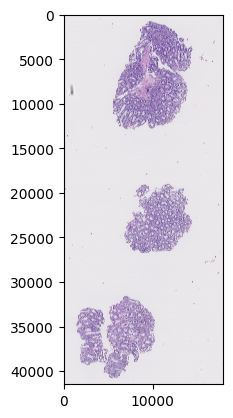

In [22]:
# Open the NDPI file
slide = openslide.OpenSlide(wsi)

# Read a region of the slide (top left x, top left y, level, width, height)
region = slide.read_region(region_size[:2], 0, region_size[3:5])

# Convert region to image
region_image = np.array(region)

# The region is already a PIL image, no need to open it
plt.imshow(region)
plt.show()

## (2) - Split into tiles

In [29]:
def split_into_tiles(region, tile_size, tiles_folder='tiles'):
    # Ensure the output directory exists
    if not os.path.exists(tiles_folder):
        os.makedirs(tiles_folder)

    # Iterate over the region to create tiles
    for i in range(0, region.size[0], tile_size):
        for j in range(0, region.size[1], tile_size):
            # Crop the image to create a tile
            tile = region.crop((i, j, i + tile_size, j + tile_size))
            # Remove alpha channel
            tile = tile.convert('RGB')
            # Naming tiles based on their position
            tile_name = f'{tiles_folder}/tile_{i}_{j}.png'
            # Save the tile
            tile.save(tile_name)

In [30]:
split_into_tiles(region, tile_size)

## (3) - Prune "Background" (remove tiles with 90% white)

In [31]:
# Check if a tile is mostly white
def is_mostly_white(tile_path, white_threshold=(200, 200, 200), percentage=0.9):
    tile = Image.open(tile_path)
    data = np.array(tile)

    # Count pixels where all RGB values are above the respective thresholds
    white_pixels = np.all(data >= np.array(white_threshold), axis=-1)
    
    white_ratio = np.sum(white_pixels) / white_pixels.size

    return white_ratio >= percentage

# Clean the white tiles
def clean_white_tiles(tiles_folder, white_threshold, percentage):
    tiles = os.listdir(tiles_folder)
    removed_count = 0

    for tile_name in tiles:
        tile_path = os.path.join(tiles_folder, tile_name)
        if is_mostly_white(tile_path, white_threshold, percentage):
            os.remove(tile_path)
            removed_count += 1
    
    print(f"Removed {removed_count} tiles due to high white content.")
    print(f"{len(tiles) - removed_count} tiles left in the directory.")

In [32]:
clean_white_tiles('tiles', white_threshold, percentage)

Removed 8622 tiles due to high white content.
2718 tiles left in the directory.


## (4) - Segmentation

In [33]:
# Load the tiles
def load_tiles(tiles_folder):
    tiles = os.listdir(tiles_folder)
    tile_images = []
    for tile_name in tiles:
        tile_path = os.path.join(tiles_folder, tile_name)
        tile = Image.open(tile_path)
        tile_images.append(tile)
    return np.array(tile_images)

In [34]:
tile_images = load_tiles('tiles')

In [35]:
# Normalize the tiles
def normalize_tiles(tiles):
    normalized_tiles = []
    for tile in tiles:
        normalized_tile = normalize(np.array(tile))
        normalized_tiles.append(normalized_tile)
    return np.array(normalized_tiles)

In [36]:
normalized_tiles = normalize_tiles(tile_images)

In [37]:
preds = [Stardist_model.predict_instances(x, n_tiles=Stardist_model._guess_n_tiles(x), show_tile_progress=False)[0] for x in tqdm(normalized_tiles)]

100%|██████████| 2718/2718 [04:12<00:00, 10.76it/s]


## (5) - Splitting tiles into subtiles (cells)

In [38]:
def extract_square_patches(segmentation_maps, images, margin=10, patch_size=(64, 64)):
    all_patches = []
    patch_info = []  # List to store information about each patch

    for i, (segmentation_map, image) in enumerate(zip(segmentation_maps, images)):
        for cell_id in np.unique(segmentation_map):
            if cell_id == 0:  # Skip background
                continue

            # Find the positions of the current cell
            positions = np.where(segmentation_map == cell_id)
            min_row, min_col = np.min(positions, axis=1)
            max_row, max_col = np.max(positions, axis=1)

            # Determine the size of the square bounding box
            box_size = max(max_row - min_row, max_col - min_col) + margin

            # Calculate the center of the bounding box
            center_row = (max_row + min_row) // 2
            center_col = (max_col + min_col) // 2

            # Determine new min and max rows and columns
            start_row = max(center_row - box_size // 2, 0)
            end_row = min(center_row + box_size // 2, segmentation_map.shape[0])
            start_col = max(center_col - box_size // 2, 0)
            end_col = min(center_col + box_size // 2, segmentation_map.shape[1])

            # Extract the patch from the image
            patch = image[start_row:end_row, start_col:end_col]

            # Prepare a mask for the current cell_id within the patch
            cell_mask = segmentation_map[start_row:end_row, start_col:end_col] == cell_id

            # Store the original segmentation map for the current cell
            original_segmentation_map = segmentation_map[start_row:end_row, start_col:end_col].copy()

            # Create a segmentation map for just the current cell, setting it to 1
            single_cell_segmentation_map = np.zeros_like(segmentation_map[start_row:end_row, start_col:end_col])
            single_cell_segmentation_map[cell_mask] = 1  # Set cell pixels to 1

            # Resize the patch to the desired size
            resized_patch = cv2.resize(patch, patch_size, interpolation=cv2.INTER_LINEAR)

            # Resize the single_cell_segmentation_map to the patch size
            resized_segmentation_map = cv2.resize(single_cell_segmentation_map.astype(np.float32), patch_size, interpolation=cv2.INTER_NEAREST).astype(np.uint8)

            # Store the patch and its corresponding information
            all_patches.append(resized_patch)
            patch_info.append({
                'image_index': i,  # Index of the original image
                'cell_id': cell_id,  # Identifier of the cell in the segmentation map
                'segmentation_map': resized_segmentation_map,  # Resized segmentation map portion for the patch
                'original_segmentation_map': original_segmentation_map,  # Original scale segmentation map
                'tl_corner': (start_col, start_row),  # Top-left corner of the patch in the original image
                'patch_size': (end_col - start_col, end_row - start_row),  # Original Width and Height of the patch before resize
                'is_neutrophil': None  # Placeholder for classification result
            })

    return np.array(all_patches), patch_info

In [39]:
# Get all patches and labels
patches, patch_info = extract_square_patches(preds, tile_images)

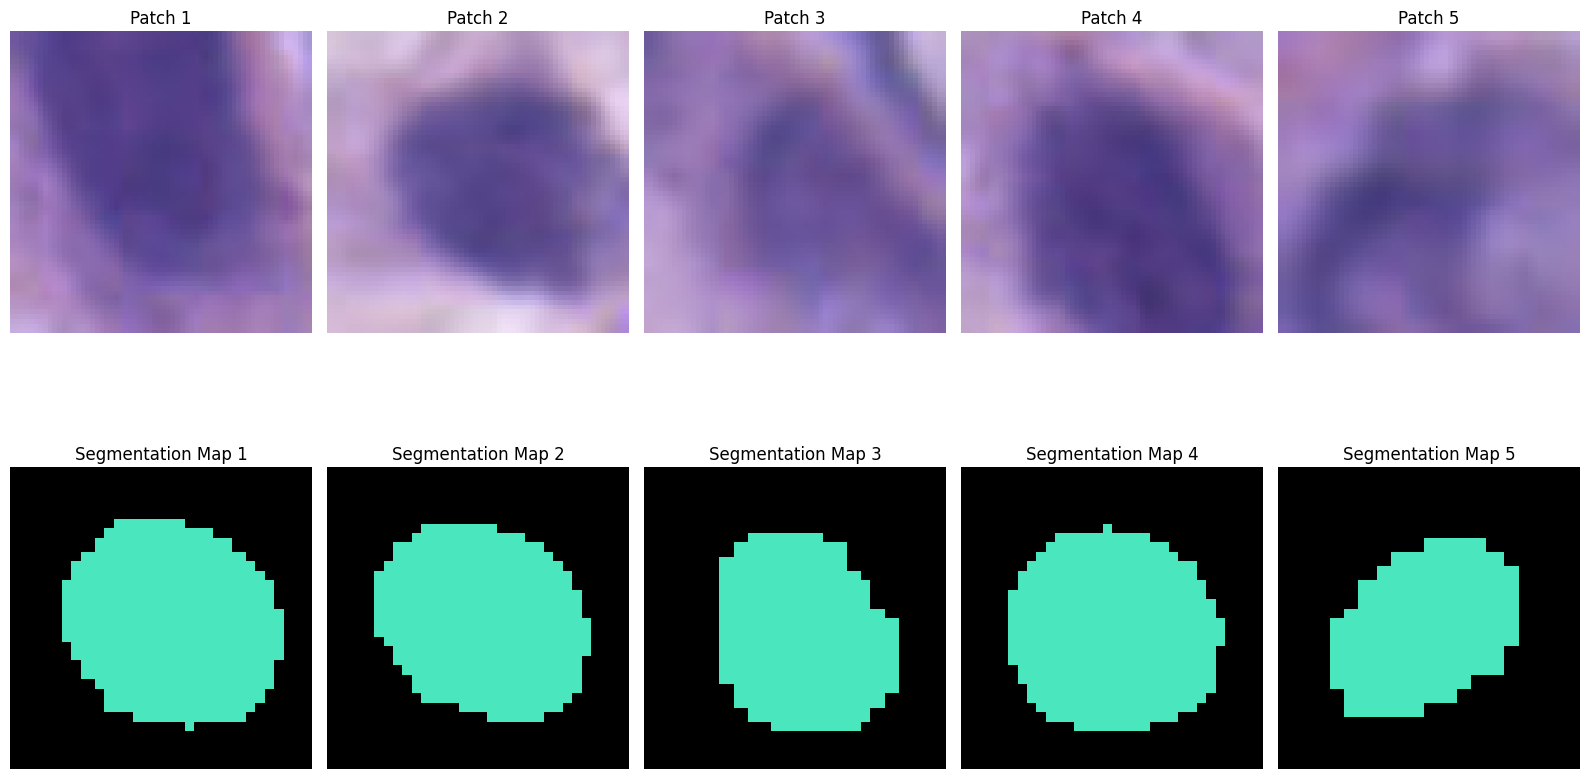

In [40]:
# Create a figure with subplots in 2 rows and 5 columns
plt.figure(figsize=(16, 10))

# Plot each patch and its corresponding segmentation map in the same column
for i in range(5):
    # Plot patch
    plt.subplot(2, 5, i + 1)
    plt.imshow(patches[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Patch {i+1}')

    # Plot segmentation map
    plt.subplot(2, 5, i + 6)
    plt.imshow(patch_info[i]['segmentation_map'], cmap=lbl_cmap)
    plt.axis('off')
    plt.title(f'Segmentation Map {i+1}')

plt.tight_layout()
plt.show()

In [41]:
# Amount of patches
print("Amount of patches:", len(patches))

Amount of patches: 173809


## (6) - Classification

In [42]:
# Define a Dataset and DataLoader for the Patches
class PatchDataset(Dataset):
    def __init__(self, patches):
        self.patches = patches
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch = self.patches[idx]
        return self.transform(patch)

In [43]:
# Function to predict patches in batches using MPS
def predict_patches(patches, threshold, batch_size=32):
    # Create a DataLoader for the patches
    dataset = PatchDataset(patches)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Set the model to evaluation mode
    Classifier_model.eval()
    results = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            batch = batch.to(device)  # Move batch to MPS device and ensure it is float32
            batch = batch.type(torch.float32)  # Ensure batch is float32 for MPS compatibility
            # Predict the batch
            outputs = Classifier_model(batch)
            probabilities = torch.sigmoid(outputs)  # Convert outputs to probabilities
            preds = (probabilities > threshold).cpu().numpy()  # Convert probabilities to binary predictions

            results.extend(preds)

    return results

# Usage
predictions = predict_patches(patches, clas_threshold, batch_size=32)

# Update patch_info with the predictions
for i, pred in enumerate(predictions):
    patch_info[i]['is_neutrophil'] = pred

Predicting: 100%|██████████| 5432/5432 [01:42<00:00, 53.03it/s]


In [44]:
# Count the number of neutrophils and non-neutrophils
neutrophil = []
not_neutrophil = []

for patch in patch_info:
    if patch['is_neutrophil'] == 1:
        neutrophil.append(patch)
    else:
        not_neutrophil.append(patch)

print("Neutrophils:", len(neutrophil))
print("Not Neutrophils:", len(not_neutrophil))

Neutrophils: 1869
Not Neutrophils: 171940


## (7) - Map subtiles to correct tiles

In [45]:
def reconstruct_segmentation_maps(images, patch_info):
    # Create a list of zeros arrays for each image
    full_segmentation_maps = [np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8) for image in images]

    # Iterate over each patch information and place it back to its original location
    for info in patch_info:
        if info['is_neutrophil']:  # Check if the patch is classified as neutrophil
            img_idx = info['image_index']  # Index of the original image
            tl_col, tl_row = info['tl_corner']  # Top-left corner coordinates
            orig_seg_map = info['original_segmentation_map']  # Use the original segmentation map

            # Calculate the exact position where the patch should be placed
            end_row = tl_row + orig_seg_map.shape[0]
            end_col = tl_col + orig_seg_map.shape[1]

            # Determine the overlapping area sizes
            overlap_height = min(end_row, full_segmentation_maps[img_idx].shape[0]) - tl_row
            overlap_width = min(end_col, full_segmentation_maps[img_idx].shape[1]) - tl_col

            # Place or blend the original segmentation map back into the full image's segmentation map
            full_segmentation_maps[img_idx][tl_row:tl_row + overlap_height, tl_col:tl_col + overlap_width] = np.maximum(
                full_segmentation_maps[img_idx][tl_row:tl_row + overlap_height, tl_col:tl_col + overlap_width],
                orig_seg_map[:overlap_height, :overlap_width])

    return full_segmentation_maps

# Assuming `images` and `patch_info` are already defined
full_maps = reconstruct_segmentation_maps(tile_images, patch_info)

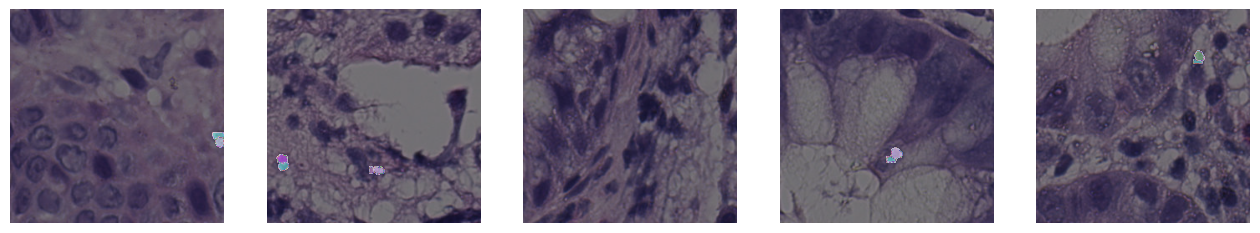

In [46]:
plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(tile_images[i])
    plt.imshow(full_maps[i], cmap=lbl_cmap, alpha=0.5)
    plt.axis('off')
plt.show()

## (8) - Map tiles to WSI (RoI)

In [52]:
# Function to reconstruct segmentation maps
def reconstruct_segmentation_maps(images, patch_info):
    full_segmentation_maps = [np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8) for image in images]
    for info in patch_info:
        if info['is_neutrophil']:
            img_idx = info['image_index']
            tl_col, tl_row = info['tl_corner']
            orig_seg_map = info['original_segmentation_map']
            end_row = tl_row + orig_seg_map.shape[0]
            end_col = tl_col + orig_seg_map.shape[1]
            overlap_height = min(end_row, full_segmentation_maps[img_idx].shape[0]) - tl_row
            overlap_width = min(end_col, full_segmentation_maps[img_idx].shape[1]) - tl_col
            full_segmentation_maps[img_idx][tl_row:tl_row + overlap_height, tl_col:tl_col + overlap_width] = np.maximum(
                full_segmentation_maps[img_idx][tl_row:tl_row + overlap_height, tl_col:tl_col + overlap_width],
                orig_seg_map[:overlap_height, :overlap_width])
    return full_segmentation_maps

# Assuming images and patch_info are already defined
full_maps = reconstruct_segmentation_maps(tile_images, patch_info)

# Define the size of the region and initialize a blank image
full_segmentation_map = np.zeros((41472, 17920), dtype=np.uint8)

# Folder where the tiles are stored
tiles_folder = 'tiles'

# List all tile image files
tile_files = os.listdir(tiles_folder)

# Check that there is a segmentation map for every tile file
assert len(tile_files) == len(full_maps), "Mismatch in the number of tiles and segmentation maps."

# Iterate over each tile file and the corresponding segmentation map
for file, seg_map in zip(tile_files, full_maps):
    if file.endswith('.png'):
        parts = file[:-4].split('_')
        try:
            x, y = int(parts[1]), int(parts[2])
            if isinstance(seg_map, Image.Image):
                seg_map = np.array(seg_map)
            elif not isinstance(seg_map, np.ndarray):
                print(f"Skipping non-array data for file {file}")
                continue
            seg_map = np.where(seg_map > 0, 255, 0).astype(np.uint8)
            start_y, end_y = y, y + seg_map.shape[0]
            start_x, end_x = x, x + seg_map.shape[1]

            # Corrected boundary checking
            if end_y > full_segmentation_map.shape[0] or end_x > full_segmentation_map.shape[1]:
                print(f"Segmentation map for {file} is out of bounds.")
                continue

            full_segmentation_map[start_y:end_y, start_x:end_x] = np.maximum(
                full_segmentation_map[start_y:end_y, start_x:end_x], seg_map)
        except (ValueError, IndexError) as e:
            print(f"Skipping file {file} due to error: {e}")

# Check if the full segmentation map has any non-zero values
if np.max(full_segmentation_map) == 0:
    print("The full segmentation map is empty after processing.")

# Convert the full segmentation map to an RGB image for visualization
seg_map_rgb = np.stack([full_segmentation_map]*3, axis=-1)

## (9) - Heatmap

In [62]:
def create_heatmaps(seg_map, sigma=5):
    epsilon = 1e-10  # Non-zero division
    heatmap = cv2.GaussianBlur(seg_map.astype(np.float32), (0, 0), sigma)
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + epsilon)
    return heatmap

def zoom_heatmap(image, heatmap, x, y, width, height):
    zoomed_image = image[y:y+height, x:x+width]
    zoomed_heatmap = heatmap[y:y+height, x:x+width]
    return zoomed_image, zoomed_heatmap

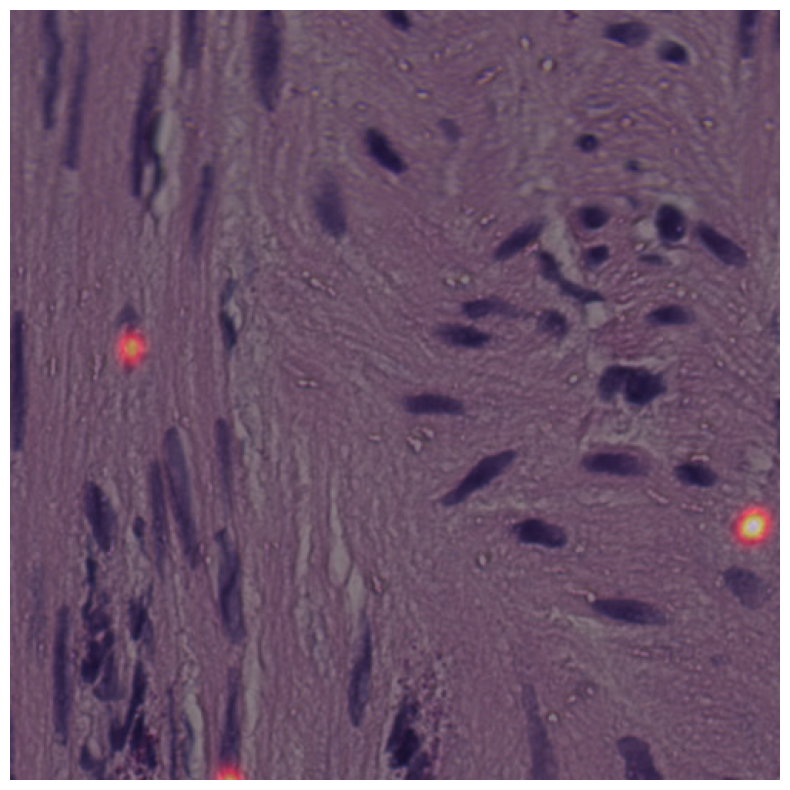

In [63]:
# Create heatmap
heatmap = create_heatmaps(full_segmentation_map)

# Define the region of interest (ROI)
roi_x, roi_y = 9000, 5000  # Top-left corner coordinates
roi_width, roi_height = 500, 500  # Dimensions of the ROI

# Get the zoomed-in image and heatmap
zoomed_image, zoomed_heatmap = zoom_heatmap(region_image, heatmap, roi_x, roi_y, roi_width, roi_height)

# Display the zoomed-in image with the heatmap overlay
plt.figure(figsize=(10, 10))
plt.imshow(zoomed_image)
plt.imshow(zoomed_heatmap, cmap='hot', alpha=0.5)  # Overlay heatmap with transparency
plt.axis('off')
plt.show()

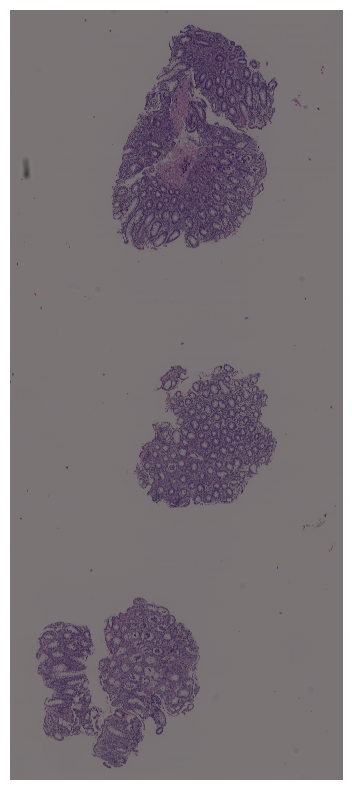

In [65]:
# Display the full heatmap overlay on the region image
plt.figure(figsize=(10, 10))
plt.imshow(region_image)
plt.imshow(heatmap, cmap='hot', alpha=0.5)  # Overlay heatmap with transparency
plt.axis('off')
plt.show()